In [1]:
import praw
import pandas as pd
import re
import emoji
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# === Reddit API Setup ===
reddit = praw.Reddit(
    client_id='q_dYyqYYdNNInGsM-lC9Xg',
    client_secret='pLigWA6vX6llH7NjWBhVWmg-gJjKvg',
    user_agent='script:gaming_trend (by /u/HiGhastlyy)'
)

In [8]:
# === Base game to subreddit variants mapping ===
GAME_SUBREDDITS = {
    "Genshin Impact": ["genshin_impact", "GenshinImpact"],
    "Valorant": ["valorant", "ValorantCompetitive"],
    "GTA": ["GTA", "GTAOnline", "GTA6", "GrandTheftAutoV", "GTAV", "GTAV_Mods"],
    "League of Legends": ["leagueoflegends", "summonerschool", "LeagueConnect", "LeagueOfLegendsSFW"],
    "Gaming": ["gaming", "pcgaming", "Games", "Gamers","videogames"],
    "Call Of Duty": ["CallOfDuty", "CODWarzone","CodZombies", "CallOfDutyMobile","CODMobile","modernwarfare"],
    "Minecraft":  ['Minecraft','minecraftsuggestions','MinecraftDungeons','MinecraftServer'],
    "The Sims" : ['thesims','Sims4','TheSimsBuilding','Sims3', 'thesims4'],
    "Overwatch" : ['Overwatch', 'OverwatchLeague', 'Competitiveoverwatch', 'Competitiveoverwatch'],
    "Skyrim": ['skyrim', 'skyrimmods', 'SkyrimModsXbox', 'SkyrimTogether'],
    "Roblox": ['roblox', 'RobloxGame', 'GoCommitDie', 'RobloxDevelopers'],
}

In [9]:
# === Text cleaning ===
def clean_text(text):
    if not text:
        return ""
    text = text.encode("ascii", errors="ignore").decode()
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# === Bot Detection ===
def is_suspected_bot(posts, threshold=5):
    duplicates = defaultdict(int)
    for p in posts:
        key = (p['author'], p['cleaned'])
        duplicates[key] += 1
    return {author for (author, _), count in duplicates.items() if count >= threshold}


In [10]:
def scrape_game_posts(game_name, subreddit_list, start_year=2020, end_year=2024, year_cap=200):
    print(f"\nScraping for '{game_name}'...")
    year_counts = defaultdict(int)
    collected = []

    def try_add(post, sub):
        if post.stickied or not post.title:
            return False

        created = datetime.utcfromtimestamp(post.created_utc)
        year = created.year
        if year < start_year or year > end_year:
            return False

        if year_counts[year] >= year_cap:
            return False

        cleaned_title = clean_text(post.title)
        if len(cleaned_title) < 10:
            return False

        post_data = {
            'game': game_name,
            'subreddit': sub,
            'author': str(post.author),
            'created_utc': created.isoformat(),
            'year': year,
            'score': post.score,
            'original_title': post.title,
            'cleaned': cleaned_title
        }

        key = (post_data['author'], post_data['original_title'], year)
        if key in seen:
            return False

        collected.append(post_data)
        seen.add(key)
        year_counts[year] += 1
        return True

    seen = set()

    for sub in subreddit_list:
        subreddit = reddit.subreddit(sub)
        print(f"  ➤ Scanning r/{sub}")

        MODES = [
            ("top", subreddit.top(limit=1000, time_filter="all")),
            ("new", subreddit.new(limit=1000)),
            ("hot", subreddit.hot(limit=1000)),
            ("rising", subreddit.rising(limit=250)),
        ]

        for mode_name, post_iter in MODES:
            if all(year_counts[y] >= year_cap for y in range(start_year, end_year + 1)):
                break  # Exit if all years are filled

            print(f"     → Trying .{mode_name}()")
            for post in tqdm(post_iter, desc=f"{sub} [{mode_name}]"):
                if all(year_counts[y] >= year_cap for y in range(start_year, end_year + 1)):
                    break
                try_add(post, sub)

    # Log any underfilled years
    for y in range(start_year, end_year + 1):
        if year_counts[y] < year_cap:
            print(f"⚠️  [{game_name}] Year {y} only has {year_counts[y]} posts")

    return collected


In [11]:
# === Run scraper across all games ===
all_posts = []

for game, subs in GAME_SUBREDDITS.items():
    all_posts.extend(scrape_game_posts(game, subs, year_cap=1000))

# === Filter out bot-like users ===
bot_users = is_suspected_bot(all_posts)
filtered_posts = [p for p in all_posts if p['author'] not in bot_users]


Scraping for 'Genshin Impact'...
  ➤ Scanning r/genshin_impact
     → Trying .top()


genshin_impact [top]: 0it [00:00, ?it/s]C:\Users\Ghastly\AppData\Local\Temp\ipykernel_36044\4008696106.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  created = datetime.utcfromtimestamp(post.created_utc)
genshin_impact [top]: 999it [00:24, 41.21it/s]


     → Trying .new()


genshin_impact [new]: 987it [00:19, 49.64it/s]


     → Trying .hot()


genshin_impact [hot]: 779it [00:16, 46.89it/s]


     → Trying .rising()


genshin_impact [rising]: 25it [00:00, 38.32it/s]


  ➤ Scanning r/GenshinImpact
     → Trying .top()


GenshinImpact [top]: 988it [00:17, 57.51it/s]


     → Trying .new()


GenshinImpact [new]: 992it [00:16, 59.83it/s]


     → Trying .hot()


GenshinImpact [hot]: 964it [00:16, 58.77it/s]


     → Trying .rising()


GenshinImpact [rising]: 25it [00:00, 40.02it/s]


⚠️  [Genshin Impact] Year 2020 only has 147 posts
⚠️  [Genshin Impact] Year 2021 only has 653 posts
⚠️  [Genshin Impact] Year 2022 only has 117 posts
⚠️  [Genshin Impact] Year 2023 only has 89 posts
⚠️  [Genshin Impact] Year 2024 only has 421 posts

Scraping for 'Valorant'...
  ➤ Scanning r/valorant
     → Trying .top()


valorant [top]: 985it [00:19, 50.83it/s]


     → Trying .new()


valorant [new]: 959it [00:16, 57.48it/s]


     → Trying .hot()


valorant [hot]: 656it [00:12, 52.59it/s]


     → Trying .rising()


valorant [rising]: 25it [00:00, 38.33it/s]


  ➤ Scanning r/ValorantCompetitive
     → Trying .top()


ValorantCompetitive [top]: 900it [00:20, 44.04it/s]


     → Trying .new()


ValorantCompetitive [new]: 981it [00:19, 49.98it/s]


     → Trying .hot()


ValorantCompetitive [hot]: 939it [00:19, 48.11it/s]


     → Trying .rising()


ValorantCompetitive [rising]: 25it [00:00, 29.11it/s]


⚠️  [Valorant] Year 2020 only has 389 posts
⚠️  [Valorant] Year 2021 only has 574 posts
⚠️  [Valorant] Year 2022 only has 397 posts
⚠️  [Valorant] Year 2023 only has 185 posts
⚠️  [Valorant] Year 2024 only has 165 posts

Scraping for 'GTA'...
  ➤ Scanning r/GTA
     → Trying .top()


GTA [top]: 983it [00:18, 53.37it/s]


     → Trying .new()


GTA [new]: 970it [00:18, 51.49it/s]


     → Trying .hot()


GTA [hot]: 918it [00:18, 50.93it/s]


     → Trying .rising()


GTA [rising]: 25it [00:00, 36.19it/s]


  ➤ Scanning r/GTAOnline
     → Trying .top()


GTAOnline [top]: 998it [00:20, 49.80it/s]


     → Trying .new()


GTAOnline [new]: 982it [00:21, 44.73it/s]


     → Trying .hot()


GTAOnline [hot]: 629it [00:15, 41.63it/s]


     → Trying .rising()


GTAOnline [rising]: 25it [00:00, 27.56it/s]


  ➤ Scanning r/GTA6
     → Trying .top()


GTA6 [top]: 983it [00:21, 45.60it/s]


     → Trying .new()


GTA6 [new]: 949it [00:24, 38.14it/s]


     → Trying .hot()


GTA6 [hot]: 489it [00:12, 39.55it/s]


     → Trying .rising()


GTA6 [rising]: 25it [00:00, 33.72it/s]


  ➤ Scanning r/GrandTheftAutoV
     → Trying .top()


GrandTheftAutoV [top]: 997it [00:15, 65.65it/s]


     → Trying .new()


GrandTheftAutoV [new]: 970it [00:19, 51.01it/s]


     → Trying .hot()


GrandTheftAutoV [hot]: 951it [00:18, 52.36it/s]


     → Trying .rising()


GrandTheftAutoV [rising]: 25it [00:00, 36.08it/s]


  ➤ Scanning r/GTAV
     → Trying .top()


GTAV [top]: 995it [00:20, 48.45it/s]


     → Trying .new()


GTAV [new]: 981it [00:18, 53.20it/s]


     → Trying .hot()


GTAV [hot]: 981it [00:19, 50.05it/s]


     → Trying .rising()


GTAV [rising]: 25it [00:00, 36.66it/s]


  ➤ Scanning r/GTAV_Mods
     → Trying .top()


GTAV_Mods [top]: 999it [00:20, 49.85it/s]


     → Trying .new()


GTAV_Mods [new]: 862it [00:14, 58.34it/s]


     → Trying .hot()


GTAV_Mods [hot]: 563it [00:10, 54.44it/s]


     → Trying .rising()


GTAV_Mods [rising]: 25it [00:00, 40.02it/s]


⚠️  [GTA] Year 2021 only has 970 posts
⚠️  [GTA] Year 2022 only has 277 posts
⚠️  [GTA] Year 2023 only has 338 posts

Scraping for 'League of Legends'...
  ➤ Scanning r/leagueoflegends
     → Trying .top()


leagueoflegends [top]: 987it [00:21, 46.98it/s]


     → Trying .new()


leagueoflegends [new]: 946it [00:16, 55.87it/s]


     → Trying .hot()


leagueoflegends [hot]: 656it [00:12, 50.82it/s]


     → Trying .rising()


leagueoflegends [rising]: 25it [00:00, 31.06it/s]


  ➤ Scanning r/summonerschool
     → Trying .top()


summonerschool [top]: 990it [00:20, 49.36it/s]


     → Trying .new()


summonerschool [new]: 970it [00:17, 55.10it/s]


     → Trying .hot()


summonerschool [hot]: 786it [00:12, 61.27it/s]


     → Trying .rising()


summonerschool [rising]: 25it [00:00, 37.83it/s]


  ➤ Scanning r/LeagueConnect
     → Trying .top()


LeagueConnect [top]: 997it [00:17, 56.86it/s]


     → Trying .new()


LeagueConnect [new]: 986it [00:13, 74.12it/s]


     → Trying .hot()


LeagueConnect [hot]: 961it [00:13, 71.54it/s]


     → Trying .rising()


LeagueConnect [rising]: 25it [00:00, 45.56it/s]


  ➤ Scanning r/LeagueOfLegendsSFW
     → Trying .top()


LeagueOfLegendsSFW [top]: 999it [00:25, 39.17it/s]


     → Trying .new()


LeagueOfLegendsSFW [new]: 984it [00:23, 41.14it/s]


     → Trying .hot()


LeagueOfLegendsSFW [hot]: 999it [00:23, 43.06it/s]


     → Trying .rising()


LeagueOfLegendsSFW [rising]: 25it [00:00, 33.66it/s]


⚠️  [League of Legends] Year 2021 only has 720 posts
⚠️  [League of Legends] Year 2022 only has 209 posts
⚠️  [League of Legends] Year 2023 only has 953 posts
⚠️  [League of Legends] Year 2024 only has 325 posts

Scraping for 'Gaming'...
  ➤ Scanning r/gaming
     → Trying .top()


gaming [top]: 995it [00:18, 52.47it/s]


     → Trying .new()


gaming [new]: 889it [00:14, 62.07it/s]


     → Trying .hot()


gaming [hot]: 502it [00:09, 52.30it/s]


     → Trying .rising()


gaming [rising]: 25it [00:00, 38.02it/s]


  ➤ Scanning r/pcgaming
     → Trying .top()


pcgaming [top]: 996it [00:19, 50.20it/s]


     → Trying .new()


pcgaming [new]: 928it [00:16, 55.58it/s]


     → Trying .hot()


pcgaming [hot]: 218it [00:06, 33.53it/s]


     → Trying .rising()


pcgaming [rising]: 25it [00:00, 32.17it/s]


  ➤ Scanning r/Games
     → Trying .top()


Games [top]: 1000it [00:18, 53.30it/s]


     → Trying .new()


Games [new]: 812it [00:14, 56.25it/s]


     → Trying .hot()


Games [hot]: 361it [00:07, 48.75it/s]


     → Trying .rising()


Games [rising]: 25it [00:00, 41.13it/s]


  ➤ Scanning r/Gamers
     → Trying .top()


Gamers [top]: 996it [00:23, 41.67it/s]


     → Trying .new()


Gamers [new]: 940it [00:19, 48.82it/s]


     → Trying .hot()


Gamers [hot]: 846it [00:17, 49.62it/s]


     → Trying .rising()


Gamers [rising]: 24it [00:00, 26.25it/s]


  ➤ Scanning r/videogames
     → Trying .top()


videogames [top]: 917it [00:16, 54.69it/s]


     → Trying .new()


videogames [new]: 976it [00:17, 55.47it/s]


     → Trying .hot()


videogames [hot]: 923it [00:15, 57.71it/s]


     → Trying .rising()


videogames [rising]: 25it [00:00, 29.45it/s]


⚠️  [Gaming] Year 2020 only has 875 posts
⚠️  [Gaming] Year 2021 only has 707 posts
⚠️  [Gaming] Year 2022 only has 303 posts
⚠️  [Gaming] Year 2023 only has 217 posts
⚠️  [Gaming] Year 2024 only has 505 posts

Scraping for 'Call Of Duty'...
  ➤ Scanning r/CallOfDuty
     → Trying .top()


CallOfDuty [top]: 987it [00:18, 52.97it/s]


     → Trying .new()


CallOfDuty [new]: 973it [00:19, 49.93it/s]


     → Trying .hot()


CallOfDuty [hot]: 250it [00:08, 28.17it/s]


     → Trying .rising()


CallOfDuty [rising]: 25it [00:00, 28.59it/s]


  ➤ Scanning r/CODWarzone
     → Trying .top()


CODWarzone [top]: 997it [00:18, 52.70it/s]


     → Trying .new()


CODWarzone [new]: 974it [00:17, 55.83it/s]


     → Trying .hot()


CODWarzone [hot]: 769it [00:14, 54.52it/s]


     → Trying .rising()


CODWarzone [rising]: 25it [00:00, 40.71it/s]


  ➤ Scanning r/CodZombies
     → Trying .top()


CodZombies [top]: 997it [00:20, 49.73it/s]


     → Trying .new()


CodZombies [new]: 990it [00:19, 51.04it/s]


     → Trying .hot()


CodZombies [hot]: 841it [00:17, 47.89it/s]


     → Trying .rising()


CodZombies [rising]: 25it [00:00, 36.11it/s]


  ➤ Scanning r/CallOfDutyMobile
     → Trying .top()


CallOfDutyMobile [top]: 997it [00:18, 52.73it/s]


     → Trying .new()


CallOfDutyMobile [new]: 921it [00:19, 47.43it/s]


     → Trying .hot()


CallOfDutyMobile [hot]: 804it [00:16, 49.87it/s]


     → Trying .rising()


CallOfDutyMobile [rising]: 25it [00:00, 29.70it/s]


  ➤ Scanning r/CODMobile
     → Trying .top()


CODMobile [top]: 996it [00:19, 50.61it/s]


     → Trying .new()


CODMobile [new]: 795it [00:15, 51.65it/s]


     → Trying .hot()


CODMobile [hot]: 778it [00:13, 56.12it/s]


     → Trying .rising()


CODMobile [rising]: 25it [00:00, 28.23it/s]


  ➤ Scanning r/modernwarfare
     → Trying .top()


modernwarfare [top]: 993it [00:19, 51.81it/s]


     → Trying .new()


modernwarfare [new]: 965it [00:18, 52.27it/s]


     → Trying .hot()


modernwarfare [hot]: 812it [00:16, 48.09it/s]


     → Trying .rising()


modernwarfare [rising]: 25it [00:00, 29.95it/s]


⚠️  [Call Of Duty] Year 2022 only has 184 posts
⚠️  [Call Of Duty] Year 2023 only has 99 posts
⚠️  [Call Of Duty] Year 2024 only has 210 posts

Scraping for 'Minecraft'...
  ➤ Scanning r/Minecraft
     → Trying .top()


Minecraft [top]: 987it [00:20, 48.13it/s]


     → Trying .new()


Minecraft [new]: 953it [00:20, 46.15it/s]


     → Trying .hot()


Minecraft [hot]: 866it [00:19, 44.48it/s]


     → Trying .rising()


Minecraft [rising]: 25it [00:00, 28.53it/s]


  ➤ Scanning r/minecraftsuggestions
     → Trying .top()


minecraftsuggestions [top]: 996it [00:23, 42.84it/s]


     → Trying .new()


minecraftsuggestions [new]: 955it [00:20, 45.84it/s]


     → Trying .hot()


minecraftsuggestions [hot]: 662it [00:14, 46.93it/s]


     → Trying .rising()


minecraftsuggestions [rising]: 25it [00:00, 36.97it/s]


  ➤ Scanning r/MinecraftDungeons
     → Trying .top()


MinecraftDungeons [top]: 999it [00:19, 51.52it/s]


     → Trying .new()


MinecraftDungeons [new]: 989it [00:19, 50.63it/s]


     → Trying .hot()


MinecraftDungeons [hot]: 986it [00:18, 51.92it/s]


     → Trying .rising()


MinecraftDungeons [rising]: 25it [00:00, 27.43it/s]


  ➤ Scanning r/MinecraftServer
     → Trying .top()


MinecraftServer [top]: 1000it [00:22, 45.34it/s]


     → Trying .new()


MinecraftServer [new]: 964it [00:17, 54.52it/s]


     → Trying .hot()


MinecraftServer [hot]: 957it [00:18, 53.07it/s]


     → Trying .rising()


MinecraftServer [rising]: 25it [00:00, 30.26it/s]


⚠️  [Minecraft] Year 2022 only has 204 posts
⚠️  [Minecraft] Year 2023 only has 65 posts
⚠️  [Minecraft] Year 2024 only has 96 posts

Scraping for 'The Sims'...
  ➤ Scanning r/thesims
     → Trying .top()


thesims [top]: 1000it [00:21, 45.62it/s]


     → Trying .new()


thesims [new]: 993it [00:24, 40.28it/s]


     → Trying .hot()


thesims [hot]: 969it [00:24, 39.38it/s]


     → Trying .rising()


thesims [rising]: 25it [00:00, 27.46it/s]


  ➤ Scanning r/Sims4
     → Trying .top()


Sims4 [top]: 1000it [00:23, 43.25it/s]


     → Trying .new()


Sims4 [new]: 985it [00:27, 36.31it/s]


     → Trying .hot()


Sims4 [hot]: 401it [00:13, 30.41it/s]


     → Trying .rising()


Sims4 [rising]: 25it [00:01, 24.74it/s]


  ➤ Scanning r/TheSimsBuilding
     → Trying .top()


TheSimsBuilding [top]: 1000it [00:47, 21.12it/s]


     → Trying .new()


TheSimsBuilding [new]: 995it [00:53, 18.56it/s]


     → Trying .hot()


TheSimsBuilding [hot]: 992it [00:53, 18.67it/s]


     → Trying .rising()


TheSimsBuilding [rising]: 25it [00:00, 25.53it/s]


  ➤ Scanning r/Sims3
     → Trying .top()


Sims3 [top]: 1000it [00:24, 40.75it/s]


     → Trying .new()


Sims3 [new]: 994it [00:24, 40.68it/s]


     → Trying .hot()


Sims3 [hot]: 990it [00:24, 40.06it/s]


     → Trying .rising()


Sims3 [rising]: 25it [00:00, 29.04it/s]


  ➤ Scanning r/thesims4
     → Trying .top()


thesims4 [top]: 999it [00:28, 35.31it/s]


     → Trying .new()


thesims4 [new]: 984it [00:30, 31.80it/s]


     → Trying .hot()


thesims4 [hot]: 280it [00:11, 25.20it/s]


     → Trying .rising()


thesims4 [rising]: 25it [00:01, 24.59it/s]


⚠️  [The Sims] Year 2020 only has 767 posts
⚠️  [The Sims] Year 2021 only has 701 posts
⚠️  [The Sims] Year 2022 only has 651 posts
⚠️  [The Sims] Year 2023 only has 647 posts

Scraping for 'Overwatch'...
  ➤ Scanning r/Overwatch
     → Trying .top()


Overwatch [top]: 995it [00:19, 51.13it/s]


     → Trying .new()


Overwatch [new]: 992it [00:18, 54.43it/s]


     → Trying .hot()


Overwatch [hot]: 853it [00:16, 52.65it/s]


     → Trying .rising()


Overwatch [rising]: 25it [00:00, 31.86it/s]


  ➤ Scanning r/OverwatchLeague
     → Trying .top()


OverwatchLeague [top]: 998it [00:19, 50.99it/s]


     → Trying .new()


OverwatchLeague [new]: 966it [00:19, 50.77it/s]


     → Trying .hot()


OverwatchLeague [hot]: 909it [00:19, 47.31it/s]


     → Trying .rising()


OverwatchLeague [rising]: 25it [00:00, 33.65it/s]


  ➤ Scanning r/Competitiveoverwatch
     → Trying .top()


Competitiveoverwatch [top]: 999it [00:20, 48.53it/s]


     → Trying .new()


Competitiveoverwatch [new]: 991it [00:19, 50.98it/s]


     → Trying .hot()


Competitiveoverwatch [hot]: 992it [00:19, 51.00it/s]


     → Trying .rising()


Competitiveoverwatch [rising]: 25it [00:00, 37.37it/s]


  ➤ Scanning r/Competitiveoverwatch
     → Trying .top()


Competitiveoverwatch [top]: 999it [00:19, 52.46it/s]


     → Trying .new()


Competitiveoverwatch [new]: 991it [00:18, 54.16it/s]


     → Trying .hot()


Competitiveoverwatch [hot]: 992it [00:20, 48.96it/s]


     → Trying .rising()


Competitiveoverwatch [rising]: 25it [00:00, 35.90it/s]


⚠️  [Overwatch] Year 2020 only has 821 posts
⚠️  [Overwatch] Year 2021 only has 393 posts
⚠️  [Overwatch] Year 2022 only has 235 posts
⚠️  [Overwatch] Year 2023 only has 692 posts
⚠️  [Overwatch] Year 2024 only has 87 posts

Scraping for 'Skyrim'...
  ➤ Scanning r/skyrim
     → Trying .top()


skyrim [top]: 989it [00:21, 46.85it/s]


     → Trying .new()


skyrim [new]: 995it [00:19, 50.51it/s]


     → Trying .hot()


skyrim [hot]: 974it [00:18, 53.24it/s]


     → Trying .rising()


skyrim [rising]: 25it [00:00, 36.83it/s]


  ➤ Scanning r/skyrimmods
     → Trying .top()


skyrimmods [top]: 996it [00:21, 45.35it/s]


     → Trying .new()


skyrimmods [new]: 992it [00:15, 65.06it/s]


     → Trying .hot()


skyrimmods [hot]: 996it [00:16, 59.91it/s]


     → Trying .rising()


skyrimmods [rising]: 25it [00:00, 38.05it/s]


  ➤ Scanning r/SkyrimModsXbox
     → Trying .top()


SkyrimModsXbox [top]: 1000it [00:45, 21.83it/s]


     → Trying .new()


SkyrimModsXbox [new]: 997it [00:20, 48.28it/s]


     → Trying .hot()


SkyrimModsXbox [hot]: 999it [00:20, 48.37it/s]


     → Trying .rising()


SkyrimModsXbox [rising]: 25it [00:00, 36.93it/s]


  ➤ Scanning r/SkyrimTogether
     → Trying .top()


SkyrimTogether [top]: 995it [00:19, 50.90it/s]


     → Trying .new()


SkyrimTogether [new]: 992it [00:15, 65.58it/s]


     → Trying .hot()


SkyrimTogether [hot]: 931it [00:14, 63.12it/s]


     → Trying .rising()


SkyrimTogether [rising]: 25it [00:00, 33.45it/s]


⚠️  [Skyrim] Year 2020 only has 702 posts
⚠️  [Skyrim] Year 2021 only has 746 posts
⚠️  [Skyrim] Year 2022 only has 657 posts
⚠️  [Skyrim] Year 2023 only has 739 posts
⚠️  [Skyrim] Year 2024 only has 612 posts

Scraping for 'Roblox'...
  ➤ Scanning r/roblox
     → Trying .top()


roblox [top]: 992it [00:21, 46.68it/s]


     → Trying .new()


roblox [new]: 923it [00:18, 49.80it/s]


     → Trying .hot()


roblox [hot]: 512it [00:12, 40.35it/s]


     → Trying .rising()


roblox [rising]: 25it [00:00, 35.66it/s]


  ➤ Scanning r/RobloxGame
     → Trying .top()


RobloxGame [top]: 8it [00:00, 16.94it/s]


     → Trying .new()


RobloxGame [new]: 8it [00:00, 16.12it/s]


     → Trying .hot()


RobloxGame [hot]: 8it [00:00, 16.25it/s]


     → Trying .rising()


RobloxGame [rising]: 8it [00:00, 15.94it/s]


  ➤ Scanning r/GoCommitDie
     → Trying .top()


GoCommitDie [top]: 998it [00:18, 54.76it/s]


     → Trying .new()


GoCommitDie [new]: 997it [00:19, 50.14it/s]


     → Trying .hot()


GoCommitDie [hot]: 952it [00:18, 50.64it/s]


     → Trying .rising()


GoCommitDie [rising]: 25it [00:00, 37.93it/s]


  ➤ Scanning r/RobloxDevelopers
     → Trying .top()


RobloxDevelopers [top]: 999it [00:24, 41.55it/s]


     → Trying .new()


RobloxDevelopers [new]: 937it [00:19, 47.53it/s]


     → Trying .hot()


RobloxDevelopers [hot]: 792it [00:15, 52.01it/s]


     → Trying .rising()


RobloxDevelopers [rising]: 25it [00:00, 33.94it/s]

⚠️  [Roblox] Year 2020 only has 965 posts
⚠️  [Roblox] Year 2021 only has 607 posts
⚠️  [Roblox] Year 2022 only has 263 posts
⚠️  [Roblox] Year 2023 only has 147 posts
⚠️  [Roblox] Year 2024 only has 291 posts


In [12]:
# === Deduplicate and save ===
df = pd.DataFrame(filtered_posts)
df = df.drop_duplicates(subset=["game", "author", "original_title"])

In [13]:
# === Save to CSV ===
df.to_csv("reddit_2020_2025.csv", index=False)
print(f"\n✅ Saved {len(df)} posts across all games. Bots removed, titles cleaned, capped per year.")


✅ Saved 27998 posts across all games. Bots removed, titles cleaned, capped per year.


In [ ]:
# Load the saved CSV
file_path = "reddit_2020_2024.csv"


df = pd.read_csv(file_path)



In [16]:
# Group by game and year
game_year_counts = df.groupby(["game", "year"]).size().unstack(fill_value=0)



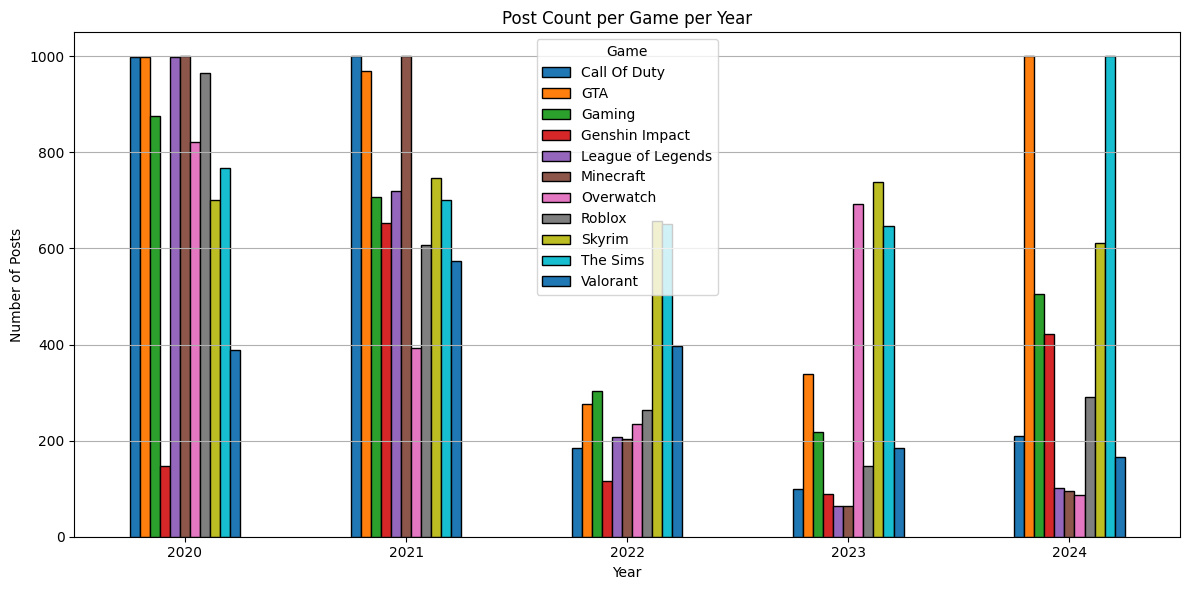

In [17]:
# Plot
game_year_counts.T.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title("Post Count per Game per Year")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.legend(title="Game")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

